<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
import scipy.special
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

from torch.optim import SGD, Adam
from torch.utils import data
import sys 
import time
import timeit

from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

print(device)



cuda


In [2]:
class Encoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims)<2: raise ValueError("Inputs list has to be at least lenght:2")
            
        self.layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
                    
    def forward(self,x):
        for i in range(len(self.layers)-1):
            x =F.relu(self.layers[i](x))   
        x = self.layers[-1](x)
        x = x/ torch.sqrt(2*torch.mean(x**2))
        return x

        
class Decoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims)<2: raise ValueError("Inputs list has to be at least lenght:2") 
        self.layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
    def forward(self,x):
        for i in range(len(self.layers)-1):
            x =F.relu(self.layers[i](x))
            
        x =  F.log_softmax(self.layers[-1](x), dim=-1 )
        return x

    
    
def awgn(x, snr):
    sigma = torch.tensor(np.sqrt(0.5/(10**(snr/10)))).to(device)
    noise = sigma * torch.randn(x.shape).to(device)
    x = x+noise 
    return x



In [3]:
M = 16
encoder = Encoder([M,10,10,2]).to(device)
decoder = Decoder([2,20,20,M]).to(device)

criterion= nn.NLLLoss()
para = list(encoder.parameters()) + list(decoder.parameters())
opt = Adam(para, lr=0.001)

start_time = time.time()
loss_sv = np.array([])

train_snr=12

totEpoch = 10000


t = tqdm(range(1,totEpoch+1), desc="loss")
for III in t:
    t.set_description("epoch={:.1f}".format(III))
    
    mess = torch.randint(0,M,size=(16000,)).to(device)
    one_hot = F.one_hot(mess).float()
    tx = encoder(one_hot)

    rx = awgn(tx, train_snr)

    y_pred = decoder(rx)
    cross_entropy = criterion(y_pred, mess) 
                                        
    opt.zero_grad()
    cross_entropy.backward()
    opt.step()

    loss_sv = np.append(loss_sv,cross_entropy.item())
         
         
  

epoch=10000.0: 100%|██████████| 10000/10000 [00:51<00:00, 192.33it/s]


In [4]:
# mess = torch.arange(M).to(device)
# one_hot = F.one_hot(mess).float()
# tx = encoder(one_hot)
# tx_tilde = perturbation(tx,  sigma_pi= explore_var)


# rx = awgn(tx, 16)


# tx1 = tx.to('cpu').detach().numpy()

# np.savez('GS_64QAM', gs_const=tx1)

NameError: name 'perturbation' is not defined

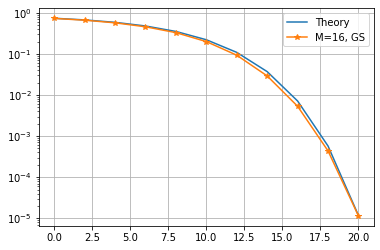

In [5]:


SNR_dB = np.arange(0,22,2)
SER = np.array([])

for snr in SNR_dB:
    num_mess = 6400
    minErr = 1e3
    minSym = 1e6
    maxSym = minErr*1e4
    totSym = 0
    totErr = 0
    while  totErr<minErr and totSym<maxSym or totSym< minSym:
        mess = torch.randint(0,M,size=(num_mess,)).to(device)
        one_hot = F.one_hot(mess).float()
        tx = encoder(one_hot)
        rx = awgn(tx, snr)
        rx_constant = rx.clone().detach().requires_grad_(False) ### no gradients in the channel model
        
        y_pred = decoder(rx_constant)
        
        m_hat = torch.argmax(y_pred, -1)
        
        err = torch.sum(torch.not_equal(mess, m_hat)).to('cpu').detach().numpy()
       
        totErr += err
        totSym += num_mess
    SER = np.append(SER, totErr/totSym)
        



snr_lin = 10**(SNR_dB/10)

k = np.sqrt(1/(2/3 * (M-1)))
SER_theory = 2*(1-1/np.sqrt(M))* scipy.special.erfc(k* np.sqrt(snr_lin)) - (1-2/np.sqrt(M)+1/M)*(scipy.special.erfc(k* np.sqrt(snr_lin)))**2
plt.semilogy(SNR_dB,SER_theory,label='Theory')
plt.semilogy(SNR_dB,SER,'-*',label='M={}, GS'.format(M))
plt.legend()
plt.grid(True)

